#### Importación de librerías

In [1]:
# imports
import numpy as np
from skimage.transform import resize
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, label_binarize
import matplotlib.pyplot as plt
import os
import io
import seaborn as sns
from PIL import Image
import umap

c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Lectura de imagenes

In [2]:
def load_image_paths_and_labels(file_path):
    """Carga las rutas de las imágenes y las etiquetas desde un archivo de texto."""
    image_paths = []
    labels = []
    with open(file_path, 'r') as file:
        for line in file.readlines():
            path, label = line.strip().split('\t')  
            image_paths.append(path)
            labels.append(int(label)) 
    return image_paths, np.array(labels)

In [3]:
# Cargar las rutas de entrenamiento y prueba junto con las etiquetas
train_image_paths, train_labels = load_image_paths_and_labels("./QuickDraw-10/train.txt")
test_image_paths, test_labels = load_image_paths_and_labels("QuickDraw-10/test.txt")

In [4]:
def load_images(image_paths):
    """Carga las imágenes y las aplana a vectores."""
    images = []
    for path in image_paths:
        with Image.open("QuickDraw-10/" + path) as img:
            img_array = np.array(img).reshape(-1)
            images.append(img_array)
    return np.array(images)

In [5]:
# Cargar y procesar las imágenes
train_images = load_images(train_image_paths)
test_images = load_images(test_image_paths)

#### Procesamiento inicial para pca y umap. 
Esto se realiza con la finalidad de tener todos los datos preparados a la hora de realizar gridSearch, training y testint.

In [6]:
#Datos escalados
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images)
test_images_scaled = scaler.transform(test_images)

In [7]:
#PCA
pca = PCA(n_components=256)
train_images_pca = pca.fit_transform(train_images_scaled)
test_images_pca = pca.transform(test_images_scaled)

In [8]:
#UMAP
umap_red = umap.UMAP(n_components=256)
train_images_umap = umap_red.fit_transform(train_images_scaled)
test_images_umap = umap_red.transform(test_images_scaled)

c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


#### Busqueda de parámetros con GridSearch

In [9]:
def sample_data_percentage(data, labels, percentage):
    """Retorna un porcentaje de los datos por cada clase"""
    data_samples = []
    label_samples = []
    classes = np.unique(labels)
    size = 1 - percentage  

    for c in classes:
        data_sample_filtered = data[labels == c]
        label_sample_filtered = labels[labels == c]

        data_sampled_c, _, label_sampled_c, _ = train_test_split(data_sample_filtered, label_sample_filtered, test_size=size, stratify=label_sample_filtered)

        data_samples.append(data_sampled_c)
        label_samples.append(label_sampled_c)

    samples_final = np.concatenate(data_samples, axis=0)
    label_final = np.concatenate(label_samples, axis=0)

    return samples_final, label_final

In [10]:
# samples a utilizar por modelo para gs
images_raw_10, labels_raw_10 = sample_data_percentage(train_images, train_labels, 0.1)
images_pca_10, labels_pca_10 = sample_data_percentage(train_images_pca, train_labels, 0.1)
images_umap_10, labels_umap_10 = sample_data_percentage(train_images_umap, train_labels, 0.1)

In [ ]:
param_grid_rbf = {
    'C': [0.1, 1, 10, 100], 
    'kernel':['rbf'],
    'gamma': ['scale', 'auto', 0.001, 0.01]
}

param_grid_poly = {
    'C': [0.1, 1, 10, 100], 
    'kernel':['poly'],
    'gamma': ['scale', 'auto', 0.001, 0.01]
}

svc = SVC()

In [12]:
# grid search raw - kernel: rbf
gs_raw_rbf = GridSearchCV(estimator=svc, param_grid=param_grid_rbf, cv=None, n_jobs=4)
gs_raw_rbf.fit(images_raw_10, labels_raw_10)

GridSearchCV(estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.001, 0.01],
                         'kernel': ['rbf']})

In [19]:
gs_raw_rbf.best_params_

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
# grid search raw - kernel: poly
gs_raw_poly = GridSearchCV(estimator=svc, param_grid=param_grid_poly, cv=None, n_jobs=4)
gs_raw_poly.fit(images_raw_10, labels_raw_10)

GridSearchCV(estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.001, 0.01],
                         'kernel': ['poly']})

In [45]:
gs_raw_poly.best_params_

{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}

In [14]:
# grid search pca - kernel: rbf
gs_pca_rbf = GridSearchCV(estimator=svc, param_grid=param_grid_rbf, cv=None, n_jobs=4)
gs_pca_rbf.fit(images_pca_10, labels_pca_10)

GridSearchCV(estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.001, 0.01],
                         'kernel': ['rbf']})

In [21]:
gs_pca_rbf.best_params_

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
# grid search pca - kernel: poly
gs_pca_poly = GridSearchCV(estimator=svc, param_grid=param_grid_poly, cv=None, n_jobs=4)
gs_pca_poly.fit(images_pca_10, labels_pca_10)

GridSearchCV(estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.001, 0.01],
                         'kernel': ['poly']})

In [41]:
gs_pca_poly.best_params_

{'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}

In [23]:
# grid search umap - kernel: rbf
gs_umap_rbf = GridSearchCV(estimator=svc, param_grid=param_grid_rbf, cv=None, n_jobs=4)
gs_umap_rbf.fit(images_umap_10, labels_umap_10)

GridSearchCV(estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.001, 0.01],
                         'kernel': ['rbf']})

In [28]:
gs_umap_rbf.best_params_

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
# grid search umap - kernel: poly
gs_umap_poly = GridSearchCV(estimator=svc, param_grid=param_grid_poly, cv=None, n_jobs=4, verbose=1)
gs_umap_poly.fit(images_umap_10, labels_umap_10)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.001, 0.01],
                         'kernel': ['poly']},
             verbose=1)

In [ ]:
gs_umap_poly.best_params_

{'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}

#### Modelos

In [19]:
# svm raw - kernel: rbf

svm_raw_rbf = SVC(kernel='rbf', C=10, gamma='scale')
svm_raw_rbf.fit(train_images_scaled, train_labels)

SVC(C=10)

In [20]:
svm_raw_rbf_pred = svm_raw_rbf.predict(test_images_scaled)

In [22]:
# accuracy general del modelo 
accuracy_score(test_labels, svm_raw_rbf_pred)

0.7195540308747856

In [ ]:
report  = classification_report(test_labels, svm_raw_rbf_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.6769    0.7333    0.7040       120
           1     0.6822    0.7213    0.7012       122
           2     0.7596    0.6031    0.6723       131
           3     0.8000    0.7931    0.7965       116
           4     0.6525    0.7333    0.6906       105
           5     0.6796    0.6796    0.6796       103
           6     0.7090    0.8190    0.7600       116
           7     0.8113    0.7107    0.7577       121
           8     0.8279    0.7769    0.8016       130
           9     0.6000    0.6176    0.6087       102

    accuracy                         0.7196      1166
   macro avg     0.7199    0.7188    0.7172      1166
weighted avg     0.7243    0.7196    0.7197      1166



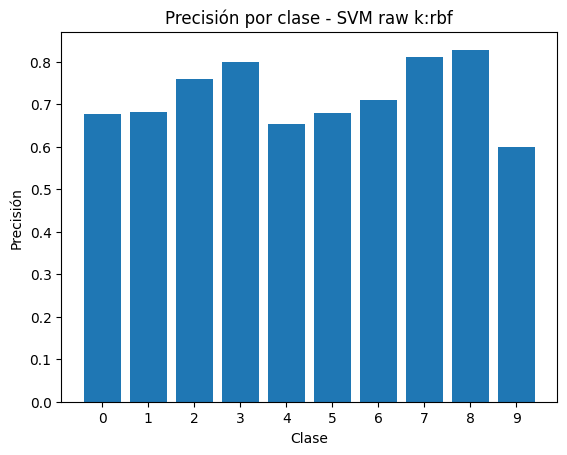

In [33]:
# Datos de precision por clase
precision = [0.6769, 0.6822, 0.7596, 0.8000, 0.6525, 0.6796, 0.7090, 0.8113, 0.8279, 0.6000]
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Crear gráfico de barras
plt.bar(classes, precision)
plt.xlabel('Clase')
plt.ylabel('Precisión')
plt.title('Precisión por clase - SVM raw k:rbf')
plt.xticks(classes) 
plt.show()


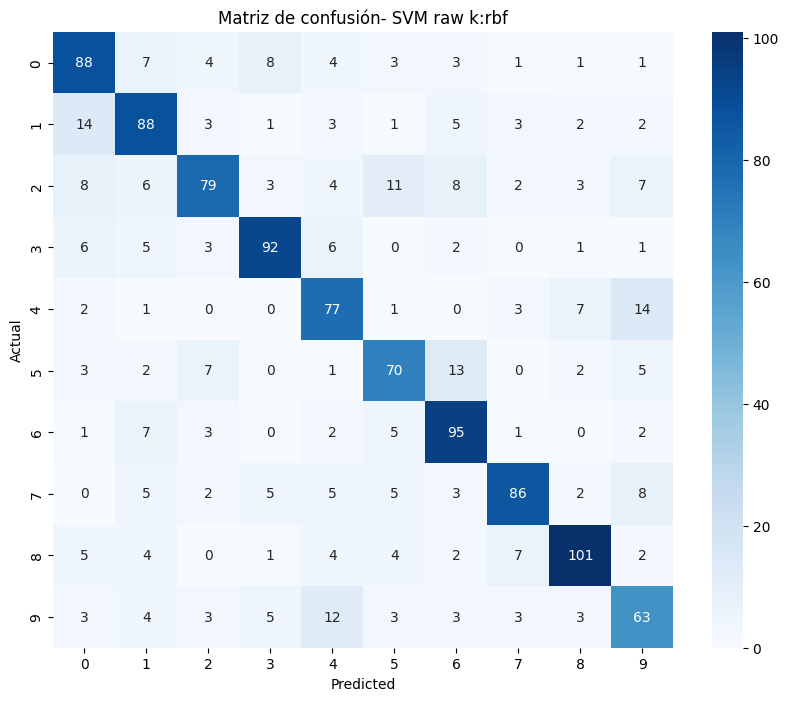

In [25]:
cm = confusion_matrix(test_labels, svm_raw_rbf_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de confusión- SVM raw k:rbf")
plt.show()

In [12]:
# svm raw - kernel: poly

svm_raw_poly = SVC(kernel='poly', C=0.1, gamma='scale')
svm_raw_poly.fit(train_images_scaled, train_labels)

SVC(C=0.1, kernel='poly')

In [24]:
svm_raw_poly_pred = svm_raw_poly.predict(test_images_scaled)

In [58]:
accuracy_score(test_labels, svm_raw_poly_pred)

0.1097770154373928

In [74]:
report  = classification_report(test_labels, svm_raw_poly_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     1.0000    0.0083    0.0165       120
           1     0.0000    0.0000    0.0000       122
           2     0.0000    0.0000    0.0000       131
           3     0.0000    0.0000    0.0000       116
           4     0.0000    0.0000    0.0000       105
           5     0.8261    0.1845    0.3016       103
           6     0.6667    0.0517    0.0960       116
           7     0.0000    0.0000    0.0000       121
           8     0.0000    0.0000    0.0000       130
           9     0.0902    1.0000    0.1655       102

    accuracy                         0.1098      1166
   macro avg     0.2583    0.1245    0.0580      1166
weighted avg     0.2501    0.1098    0.0524      1166



c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

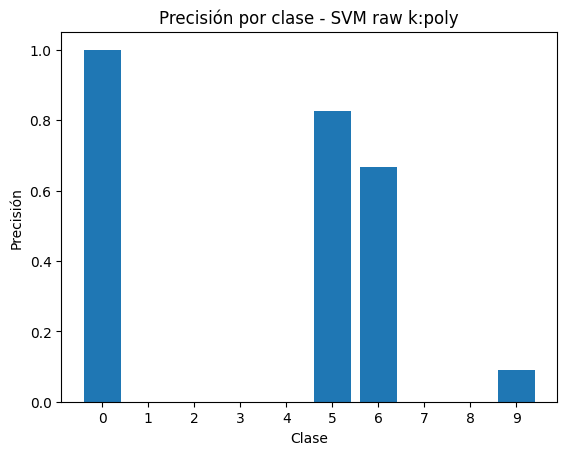

In [32]:
precision = [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8261, 0.6667, 0.0000, 0.0000, 0.0902]
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Crear gráfico de barras
plt.bar(classes, precision)
plt.xlabel('Clase')
plt.ylabel('Precisión')
plt.title('Precisión por clase - SVM raw k:poly')
plt.xticks(classes)  
plt.show()


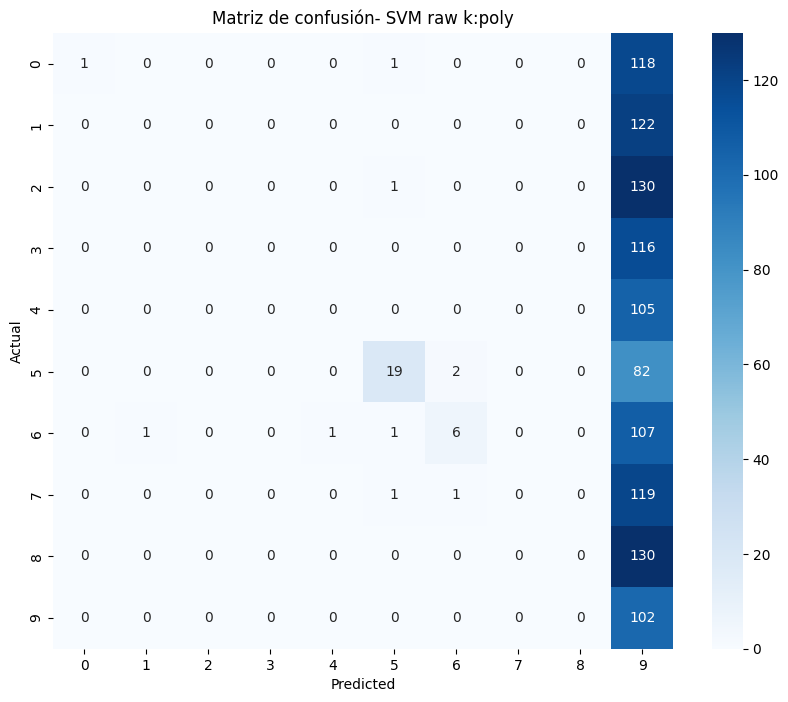

In [63]:
cm = confusion_matrix(test_labels, svm_raw_poly_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de confusión- SVM raw k:poly")
plt.show()

In [12]:
# svm pca - kernel: rbf
svm_pca_rbf = SVC(kernel='rbf', C=0.1, gamma='scale')
svm_pca_rbf.fit(train_images_pca, train_labels)

SVC(C=0.1)

In [13]:
svm_pca_rbf_pred = svm_pca_rbf.predict(test_images_pca)

In [14]:
accuracy_score(test_labels, svm_pca_rbf_pred)

0.7075471698113207

In [15]:
report  = classification_report(test_labels, svm_pca_rbf_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.7358    0.6500    0.6903       120
           1     0.7745    0.6475    0.7054       122
           2     0.7143    0.6870    0.7004       131
           3     0.7099    0.8017    0.7530       116
           4     0.5957    0.8000    0.6829       105
           5     0.7368    0.5437    0.6257       103
           6     0.6735    0.8534    0.7529       116
           7     0.8556    0.6364    0.7299       121
           8     0.7681    0.8154    0.7910       130
           9     0.5780    0.6176    0.5972       102

    accuracy                         0.7075      1166
   macro avg     0.7142    0.7053    0.7029      1166
weighted avg     0.7184    0.7075    0.7063      1166



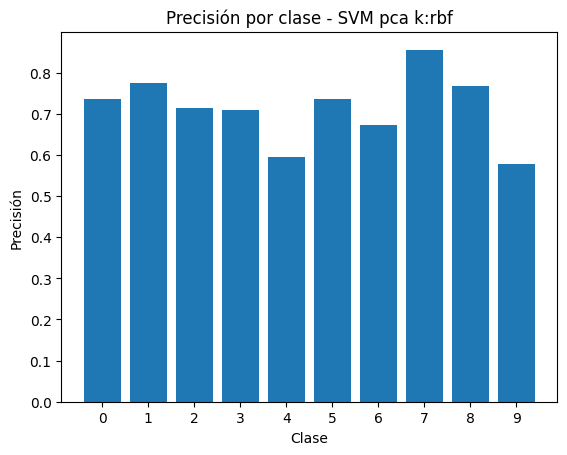

In [31]:
precision = [0.7358, 0.7745, 0.7143, 0.7099, 0.5957, 0.7368, 0.6735, 0.8556, 0.7681, 0.5780]
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Crear gráfico de barras
plt.bar(classes, precision)
plt.xlabel('Clase')
plt.ylabel('Precisión')
plt.title('Precisión por clase - SVM pca k:rbf')
plt.xticks(classes)  
plt.show()


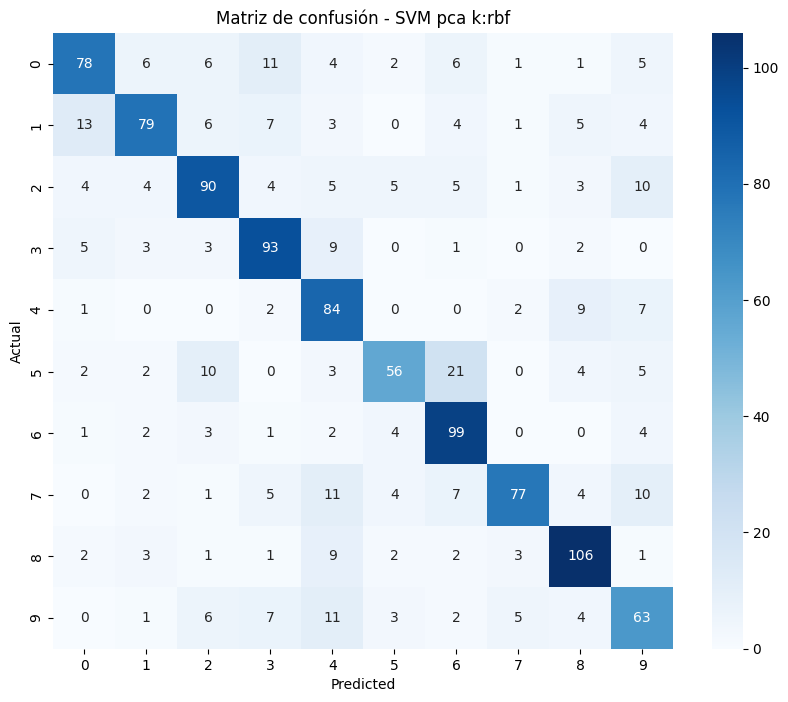

In [16]:
cm = confusion_matrix(test_labels, svm_pca_rbf_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de confusión - SVM pca k:rbf")
plt.show()

In [17]:
# svm pca - kernel: poly
svm_pca_poly = SVC(kernel='poly', C=0.1, gamma='auto')
svm_pca_poly.fit(train_images_pca, train_labels)

SVC(C=0.1, gamma='auto', kernel='poly')

In [18]:
svm_pca_poly_pred = svm_pca_poly.predict(test_images_pca)

In [19]:
accuracy_score(test_labels, svm_pca_poly_pred)

0.7161234991423671

In [20]:
report  = classification_report(test_labels, svm_pca_poly_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.8218    0.6917    0.7511       120
           1     0.7699    0.7131    0.7404       122
           2     0.6316    0.6412    0.6364       131
           3     0.8512    0.8879    0.8692       116
           4     0.4324    0.9143    0.5872       105
           5     0.7375    0.5728    0.6448       103
           6     0.9104    0.5259    0.6667       116
           7     0.8739    0.8017    0.8362       121
           8     0.8320    0.8000    0.8157       130
           9     0.6559    0.5980    0.6256       102

    accuracy                         0.7161      1166
   macro avg     0.7517    0.7147    0.7173      1166
weighted avg     0.7563    0.7161    0.7213      1166



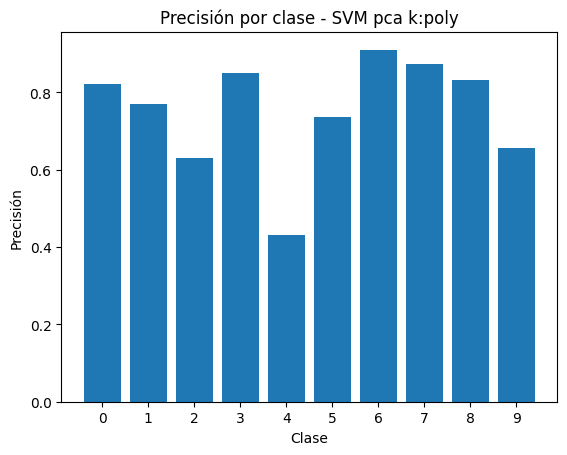

In [30]:
precision = [0.8218, 0.7699, 0.6316, 0.8512, 0.4324, 0.7375, 0.9104, 0.8739, 0.8320, 0.6559]
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Crear gráfico de barras
plt.bar(classes, precision)
plt.xlabel('Clase')
plt.ylabel('Precisión')
plt.title('Precisión por clase - SVM pca k:poly')
plt.xticks(classes)  
plt.show()


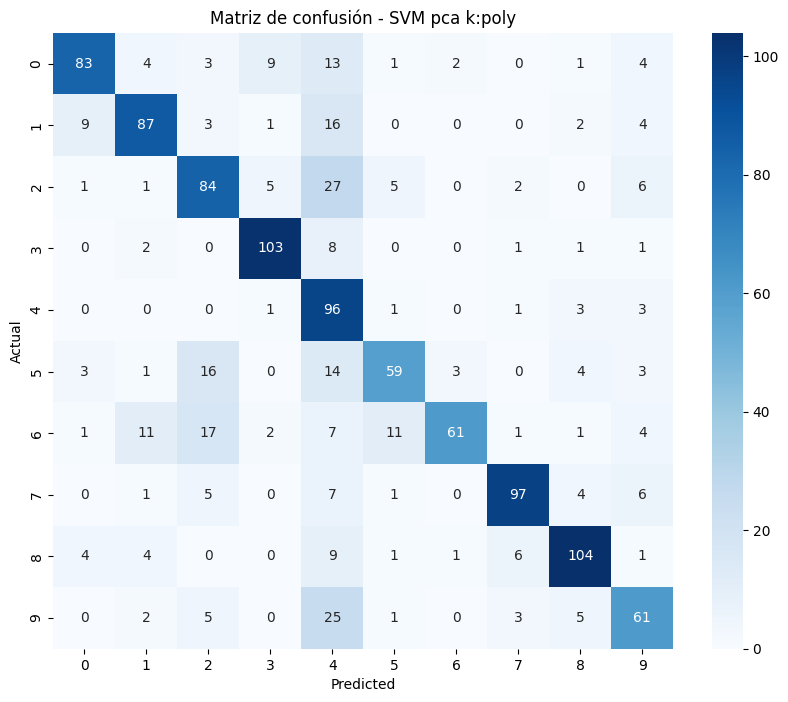

In [21]:
cm = confusion_matrix(test_labels, svm_pca_poly_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de confusión - SVM pca k:poly")
plt.show()

In [10]:
# svm umap - kernel: rbf
svm_umap_rbf = SVC(kernel='rbf', C=10, gamma='scale')
svm_umap_rbf.fit(train_images_umap, train_labels)

SVC(C=10)

In [11]:
svm_umap_rbf_pred = svm_umap_rbf.predict(test_images_umap)

In [12]:
accuracy_score(test_labels, svm_umap_rbf_pred)

0.2770154373927959

In [13]:
report  = classification_report(test_labels, svm_umap_rbf_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.3846    0.0417    0.0752       120
           1     0.2785    0.1803    0.2189       122
           2     0.2286    0.1832    0.2034       131
           3     0.3158    0.2069    0.2500       116
           4     0.1282    0.5810    0.2100       105
           5     0.5068    0.3592    0.4205       103
           6     0.2569    0.2414    0.2489       116
           7     0.5410    0.5455    0.5432       121
           8     0.8148    0.3385    0.4783       130
           9     0.2034    0.1176    0.1491       102

    accuracy                         0.2770      1166
   macro avg     0.3659    0.2795    0.2797      1166
weighted avg     0.3725    0.2770    0.2819      1166



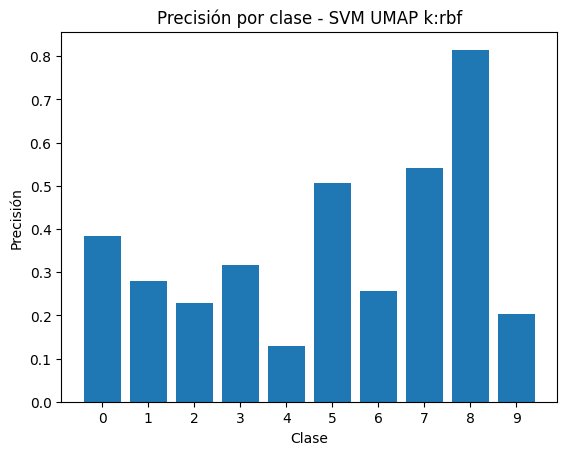

In [29]:
precision = [0.3846, 0.2785, 0.2286, 0.3158, 0.1282, 0.5068, 0.2569, 0.5410, 0.8148, 0.2034]
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Crear gráfico de barras
plt.bar(classes, precision)
plt.xlabel('Clase')
plt.ylabel('Precisión')
plt.title('Precisión por clase - SVM UMAP k:rbf')
plt.xticks(classes) 
plt.show()


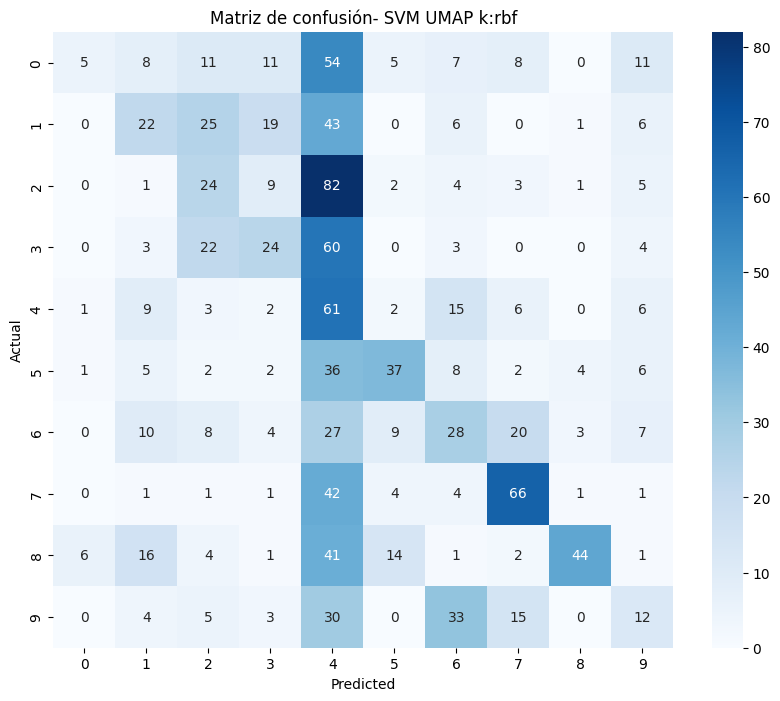

In [ ]:
cm = confusion_matrix(test_labels, svm_umap_rbf_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de confusión - SVM UMAP k:rbf")
plt.show()

In [15]:
#svm umap - kernel: poly
svm_umap_poly = SVC(kernel='poly', C=0.1, gamma='auto')
svm_umap_poly.fit(train_images_umap, train_labels)

SVC(C=0.1, gamma='auto', kernel='poly')

In [16]:
svm_umap_poly_pred = svm_umap_poly.predict(test_images_umap)

In [17]:
accuracy_score(test_labels, svm_umap_poly_pred)

0.2684391080617496

In [18]:
report  = classification_report(test_labels, svm_umap_poly_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.5000    0.0250    0.0476       120
           1     0.5263    0.1639    0.2500       122
           2     0.2258    0.2137    0.2196       131
           3     0.3393    0.1638    0.2209       116
           4     0.1278    0.7143    0.2168       105
           5     0.5636    0.3010    0.3924       103
           6     0.2530    0.1810    0.2111       116
           7     0.5312    0.5620    0.5462       121
           8     0.7959    0.3000    0.4358       130
           9     0.2250    0.0882    0.1268       102

    accuracy                         0.2684      1166
   macro avg     0.4088    0.2713    0.2667      1166
weighted avg     0.4157    0.2684    0.2692      1166



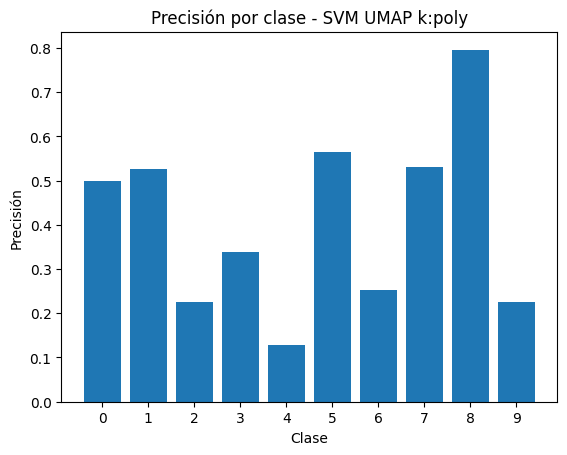

In [28]:
precision = [0.5000, 0.5263, 0.2258, 0.3393, 0.1278, 0.5636, 0.2530, 0.5312, 0.7959, 0.2250]
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Crear gráfico de barras
plt.bar(classes, precision)
plt.xlabel('Clase')
plt.ylabel('Precisión')
plt.title('Precisión por clase - SVM UMAP k:poly')
plt.xticks(classes)
plt.show()


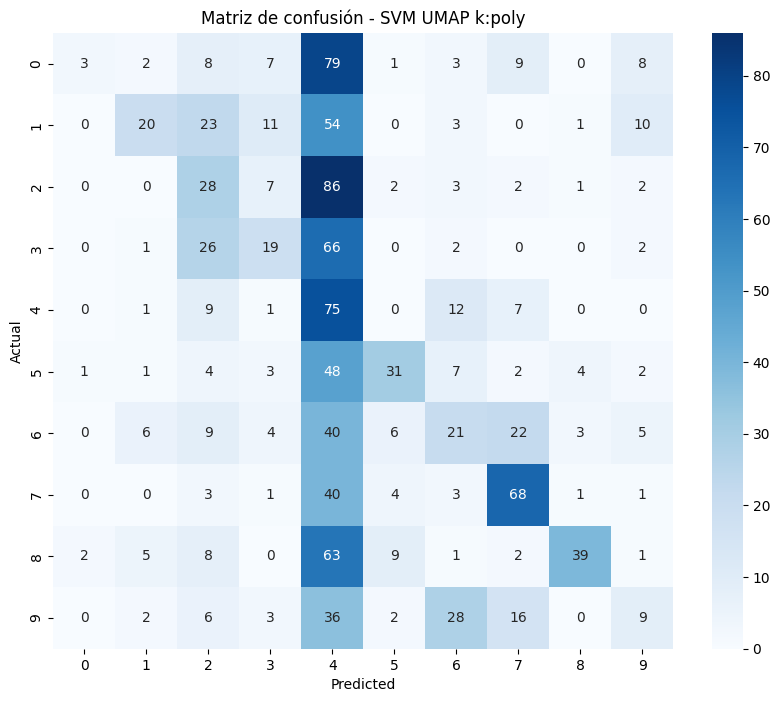

In [27]:
cm = confusion_matrix(test_labels, svm_umap_poly_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de confusión - SVM UMAP k:poly")
plt.show()